
## Import libraries and src files


In [1]:
import sys
import os
# go up one directory from notebooks/ → project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
import numpy as np
import wfdb
from src import PreProcessing
from scipy.signal import fftconvolve

import matplotlib.pyplot as plt


## Read raw data form data/100
Taking the first n samples form two channels MLII and V5
signal_list contains the the np array form of the signal values. Its a 2D(n,2) list containing MLII and V5 values. 
r_peak will store the peak values form the annotation .atr file
r_peak_time will store the time domain representation of peak values

NOTE: Do not change the sampfrom = 0 for the record, its on purpose.
Its weird how wfdb.rdrecord works.


Finally we will plot the annotation and signal_list


60s sample size:-  21600


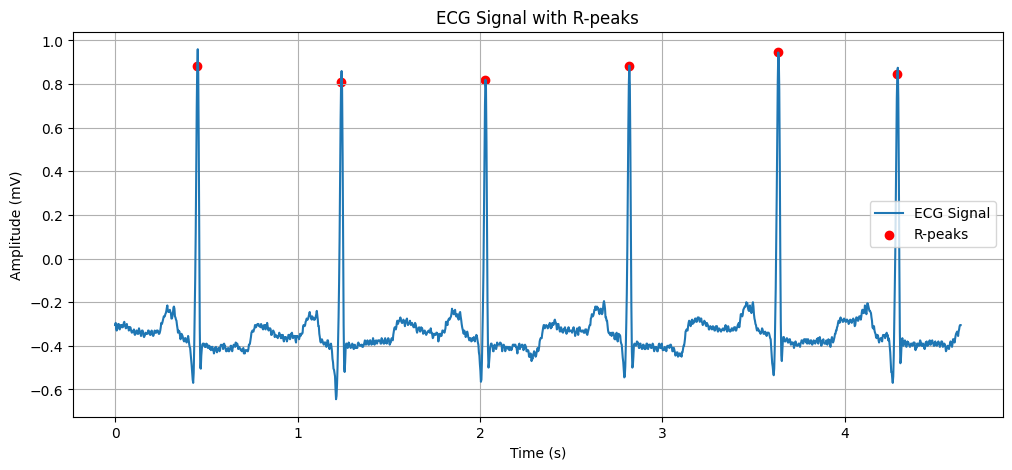

In [7]:
record_path = os.path.join(os.getcwd(), "..", "data", "100")
starting_sample = 500
ending_sample = 2170
channel_size =1

# take inputs
record,annotation =PreProcessing.record_annotation(record_path,starting_sample,ending_sample,channel_size)
fs = record.fs
print("60s sample size:- ", 60*fs)

# useful lists
signal_list = np.array(record.p_signal.tolist())
r_peak = np.array(annotation.sample.tolist())
r_peak_time = r_peak[:] / fs



# Adjust R-peak indices to match sliced signal
r_peak_local = r_peak - starting_sample
offset_peak_time = starting_sample/fs
peak_time_for_plot = r_peak_time[:] - offset_peak_time

# plot
time_axis = np.arange(len(signal_list[:,0])) / fs

plt.figure(figsize=(12,5))
plt.plot(time_axis, signal_list[:,0], label="ECG Signal")

# Mark R-peaks on the plot
plt.scatter(peak_time_for_plot, signal_list[r_peak_local,0], color="red", marker="o", label="R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.title("ECG Signal with R-peaks")
plt.legend()
plt.grid(True)
plt.show()


## Now implementing the filter on our input signal, signal_list
NOTE: The high_freq cannot be greater than fs/2 else filter will break. 
This is due to Nyquist condition i.e the sampling freq must be greater than 2 * the bandlimit frequeny


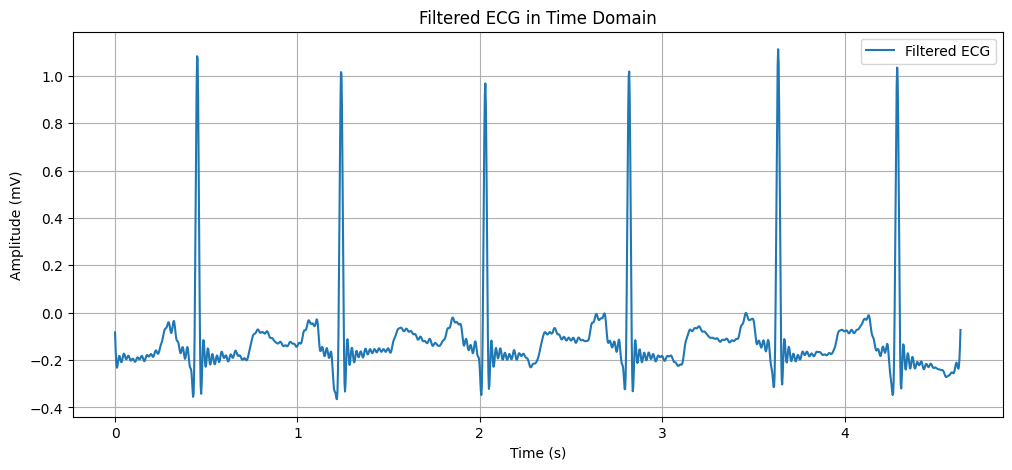

In [3]:
import src.PreProcessing as PreProcessing
import importlib
importlib.reload(PreProcessing)
#paramters
low_freq = 0.5
high_freq = 40
N = 501

#convolution
h = PreProcessing.windowedimpulseResponse(low_freq, high_freq, fs, N)

x = signal_list[:,0] #taking theMLII as the input data
y_n = fftconvolve(x, h, mode='same')

#plot

N = len(y_n)
time_axis = np.arange(N) / fs

plt.figure(figsize=(12,5))
plt.plot(time_axis, y_n, label="Filtered ECG")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.title("Filtered ECG in Time Domain")
plt.grid(True)
plt.legend()
plt.show()



## Frequency domain representation of the input and the filterd signal.


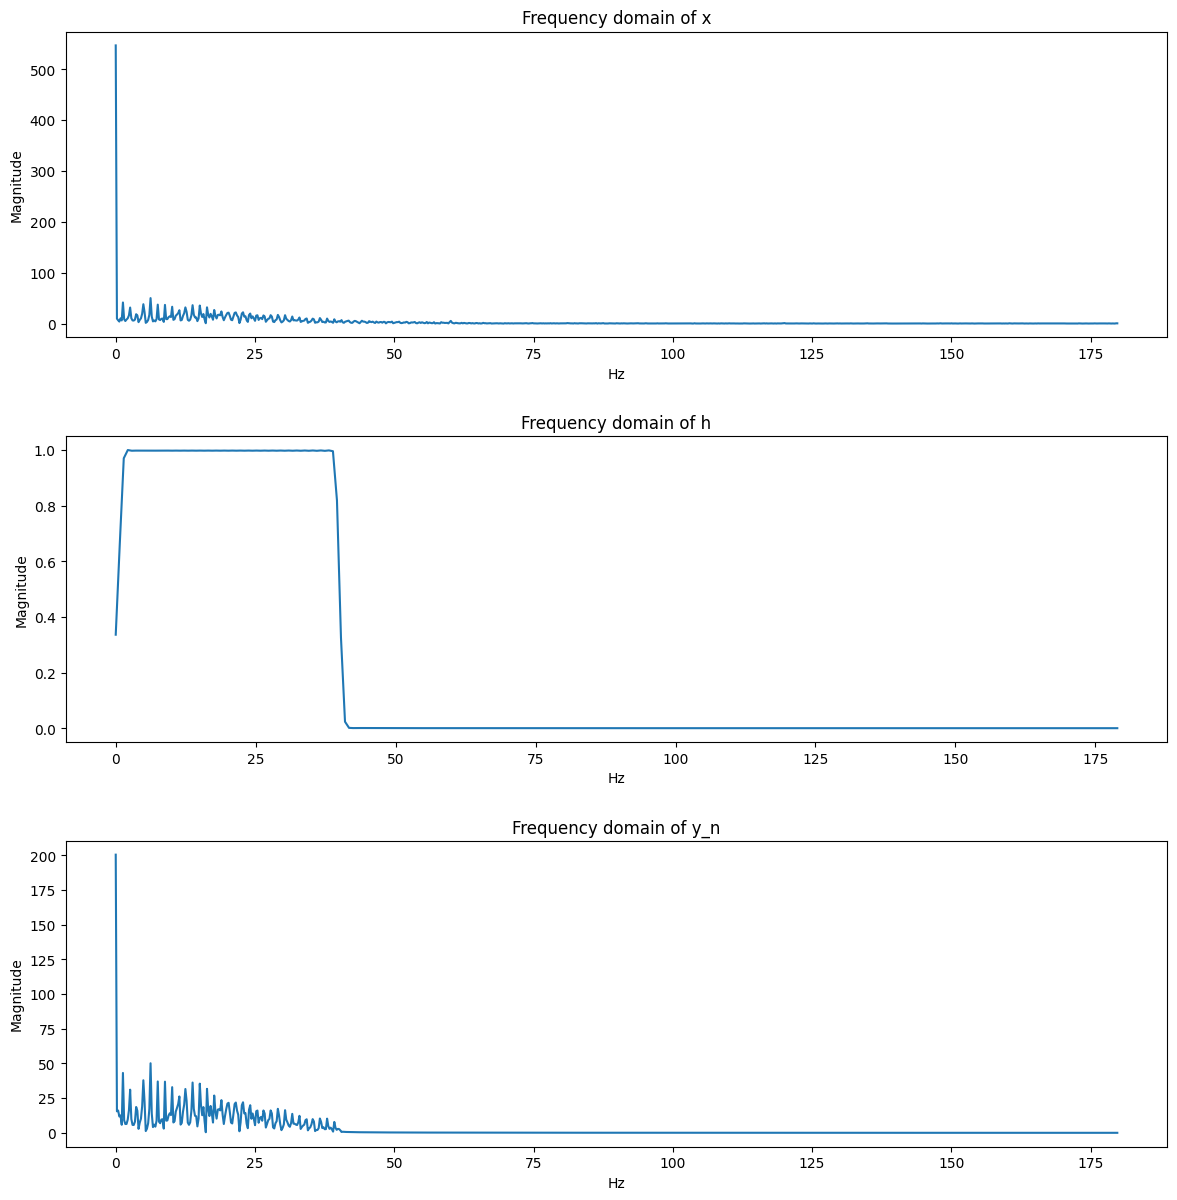

In [4]:
X_ejw = np.fft.fft(x)
Y_ejw = np.fft.fft(y_n)
H_ejw = np.fft.fft(h)
h = h / np.max(np.abs(H_ejw))
H_ejw = np.fft.fft(h)  # recompute after normalization

#plots
fig, axs = plt.subplots(3,1,figsize =(12,12))
plt.tight_layout(pad=2.0, w_pad=3.0, h_pad=5.0)

N = len(X_ejw)
k = np.arange(N//2)
frequency_axis = (fs/N) * k
axs[0].plot(frequency_axis,np.abs(X_ejw[:N//2]))
axs[0].set_title("Frequency domain of x")
axs[0].set_xlabel("Hz")
axs[0].set_ylabel("Magnitude")

axs[2].plot(frequency_axis,np.abs(Y_ejw[:N//2]))
axs[2].set_title("Frequency domain of y_n")
axs[2].set_xlabel("Hz")
axs[2].set_ylabel("Magnitude")

N = len(H_ejw)
k = np.arange(N//2)
frequency_axis = (fs/N) * k
axs[1].plot(frequency_axis,np.abs(H_ejw[:N//2]))
axs[1].set_title("Frequency domain of h")
axs[1].set_xlabel("Hz")
axs[1].set_ylabel("Magnitude")
plt.show()


## SetUp variables for further use

In [6]:

np.savez("preprocessing_data.npz",
         
         r_peak_time=r_peak_time,
         fs = fs,
        y_n = y_n
        )
